## Loading the Dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, shapiro,ttest_ind,f_oneway,zscore
import itertools
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
%matplotlib inline
import json
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.cluster import KMeans,AgglomerativeClustering
import warnings
warnings.filterwarnings("ignore")

## Import and warehouse data

In [4]:
data1= pd.read_csv("Part1 - Car name.csv")
with open("Part1 - Car-Attributes.json") as Car_Attributes:
    data_json=json.load(Car_Attributes)

In [5]:
data1.shape

(398, 1)

In [6]:
data2=pd.DataFrame(data_json)

In [7]:
data2.shape

(398, 8)

In [8]:
cardata=pd.concat([data1,data2],axis=1,)

In [9]:
cardata.shape

(398, 9)

In [1524]:
cardata.to_csv("cardata.csv",index=False)

In [1525]:
cardata.to_excel("cardata.xlsx",index=False)

In [1526]:
cardata.to_json("cardata.json")

In [10]:
cData=pd.read_json("cardata.json")

In [1528]:
cData.head()

,car_name,mpg,cyl,disp,hp,wt,acc,yr,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
1,buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
2,plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
3,amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
4,ford torino,17.0,8,302.0,140,3449,10.5,70,1


## EDA

In [11]:
cData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    object 
 1   mpg       398 non-null    float64
 2   cyl       398 non-null    int64  
 3   disp      398 non-null    float64
 4   hp        398 non-null    object 
 5   wt        398 non-null    int64  
 6   acc       398 non-null    float64
 7   yr        398 non-null    int64  
 8   origin    398 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 31.1+ KB


- This data is not complex and is good for analysis as it has a nice blend of both categorical and numerical attributes.

In [12]:
#cData.drop(["car_name"],axis=1,inplace=True)
catcols=list(cData.select_dtypes(include="object").columns)
numcols=list(cData.select_dtypes(exclude="object").columns)

In [13]:
cData.nunique()

car_name    305
mpg         129
cyl           5
disp         82
hp           94
wt          351
acc          95
yr           13
origin        3
dtype: int64

- As there are very few unique values for cyl,yr and origin, so it's safe to make them categorical instead of numeric.

In [14]:
#cyl and yr also seems to be categorical so lets update the lists
catcols.extend(["cyl","yr","origin"])
catcols.remove("hp")

In [15]:
numcols.remove("cyl")
numcols.remove("yr")
numcols.remove("origin")
numcols.append("hp")

In [16]:
print('categorical variables:  {}'.format(catcols))
print('numerical variables:  {}'.format(numcols))

categorical variables:  ['car_name', 'cyl', 'yr', 'origin']
numerical variables:  ['mpg', 'disp', 'wt', 'acc', 'hp']


## Data Cleaning

- missing/incorrect value treatment

In [17]:
#isdigit() ? in hp 
cData[cData["hp"].astype(str).str.isdigit()==False]

,car_name,mpg,cyl,disp,hp,wt,acc,yr,origin
32,ford pinto,25.0,4,98.0,?,2046,19.0,71,1
126,ford maverick,21.0,6,200.0,?,2875,17.0,74,1
330,renault lecar deluxe,40.9,4,85.0,?,1835,17.3,80,2
336,ford mustang cobra,23.6,4,140.0,?,2905,14.3,80,1
354,renault 18i,34.5,4,100.0,?,2320,15.8,81,2
374,amc concord dl,23.0,4,151.0,?,3035,20.5,82,1


In [18]:
cData["hp"]=cData["hp"].replace({"?":np.nan})


In [19]:
cData.isna().sum()

car_name    0
mpg         0
cyl         0
disp        0
hp          6
wt          0
acc         0
yr          0
origin      0
dtype: int64

In [20]:
cData["hp"]=cData["hp"].fillna(cData["hp"].median())

In [21]:
# find total duplicate entries and drop them if any
print('total duplicate rows: {}'.format(cData.duplicated().sum()))

# drop duplicate rows if any
cData = cData[~cData.duplicated()]
cData.shape

total duplicate rows: 0


(398, 9)

In [22]:
# before we move ahead it's a good practice to group all variables together having same type.
cData = pd.concat((cData[catcols], cData[numcols]), axis=1)
cData.head()

,car_name,cyl,yr,origin,mpg,disp,wt,acc,hp
0,chevrolet chevelle malibu,8,70,1,18.0,307.0,3504,12.0,130.0
1,buick skylark 320,8,70,1,15.0,350.0,3693,11.5,165.0
2,plymouth satellite,8,70,1,18.0,318.0,3436,11.0,150.0
3,amc rebel sst,8,70,1,16.0,304.0,3433,12.0,150.0
4,ford torino,8,70,1,17.0,302.0,3449,10.5,140.0


In [23]:
# save this cleaned df to csv
cData.to_csv('mpg_cleaned.csv', index=False)

In [24]:
df_cat=cData.loc[:,catcols]

In [25]:
df_num=cData.loc[:,numcols]

In [26]:
df_num

,mpg,disp,wt,acc,hp
0,18.0,307.0,3504,12.0,130.0
1,15.0,350.0,3693,11.5,165.0
2,18.0,318.0,3436,11.0,150.0
3,16.0,304.0,3433,12.0,150.0
4,17.0,302.0,3449,10.5,140.0
...,...,...,...,...,...
393,27.0,140.0,2790,15.6,86.0
394,44.0,97.0,2130,24.6,52.0
395,32.0,135.0,2295,11.6,84.0
396,28.0,120.0,2625,18.6,79.0


We will create an artificial categorical attribute named mpg_level which categorizes mpg into low, medium and high. This is done for two reasons, first it will help a lot in EDA i.e., we can bifurcate plots on the basis of mpg and secondly this is easy to understand as compared to numbers in mpg.

In [27]:
cData.describe()

,cyl,yr,origin,mpg,disp,wt,acc,hp
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,76.010050,1.572864,23.514573,193.425879,2970.424623,15.568090,104.304020
std,1.701004,3.697627,0.802055,7.815984,104.269838,846.841774,2.757689,38.222625
min,3.000000,70.000000,1.000000,9.000000,68.000000,1613.000000,8.000000,46.000000
25%,4.000000,73.000000,1.000000,17.500000,104.250000,2223.750000,13.825000,76.000000
50%,4.000000,76.000000,1.000000,23.000000,148.500000,2803.500000,15.500000,93.500000
75%,8.000000,79.000000,2.000000,29.000000,262.000000,3608.000000,17.175000,125.000000
max,8.000000,82.000000,3.000000,46.600000,455.000000,5140.000000,24.800000,230.000000


In [28]:
df_cat["mpg_level"]=pd.cut(cData["mpg"],bins=[7,17,29,50],labels=["low","Medium","High"])

In [29]:
catcols.append("mpg_level")

In [30]:
# let's look at the unique categories in `origin`, `cyl` & `yr`
# we are leaving `car_name` because it is almost unique for each entry (nothing interesting)
print("Categories in origin",df_cat["origin"].unique())
print("Categories in cylinder",df_cat["cyl"].unique())
print("Categories in year",df_cat["yr"].unique())

Categories in origin [1 3 2]
Categories in cylinder [8 4 6 3 5]
Categories in year [70 71 72 73 74 75 76 77 78 79 80 81 82]


In [31]:
# Although descriptive stats for categorical variables are not much informatic but still it's worth looking once.
# Also pandas describe function is only for numeric data and in df_cat `cyl` & `yr` and "origin are the only numeric type.
df_cat.describe()

,cyl,yr,origin
count,398.000000,398.000000,398.000000
mean,5.454774,76.010050,1.572864
std,1.701004,3.697627,0.802055
min,3.000000,70.000000,1.000000
25%,4.000000,73.000000,1.000000
50%,4.000000,76.000000,1.000000
75%,8.000000,79.000000,2.000000
max,8.000000,82.000000,3.000000


- Most of the cars in the dataset have 4 cylinder engines with a minimum of 3 and a maximum of 8 

### Analysis of Distribution

Now we analyse the distribution for each categorical feature and make some insights from the plots.

In case of categorical variables an ideal (or atleast loved) distribution is uniform,

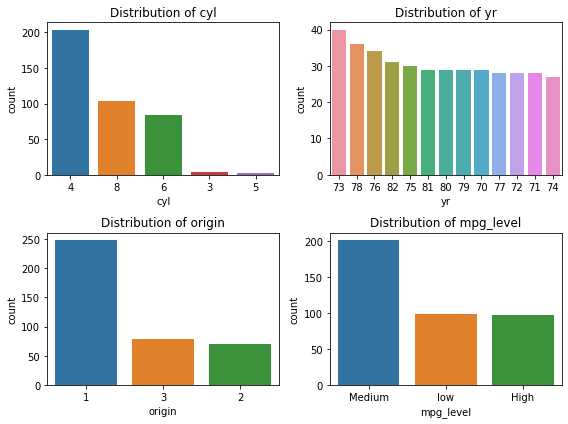

In [32]:
plt.figure(figsize=(8,6))
for i,col in enumerate(df_cat.drop("car_name",axis=1).columns):
    ax=plt.subplot(2,2,i+1)
    sns.countplot(x=df_cat[col],order=df_cat[col].value_counts().index,ax=ax)
    ax.set_title("Distribution of {}".format(col))
plt.tight_layout()

In [33]:
#proportion of dominant class
for col in df_cat.drop("car_name",axis=1).columns:
    val_counts=df_cat[col].value_counts()
    dominant_frac=val_counts.iloc[0]/len(df_cat)
    print("{} alone contributes to {}% of {}".format(val_counts.index[0],(dominant_frac*100).round(2),col))

4 alone contributes to 51.26% of cyl
73 alone contributes to 10.05% of yr
1 alone contributes to 62.56% of origin
Medium alone contributes to 50.75% of mpg_level


In [34]:
df_cat["cyl"].value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cyl, dtype: int64

In [35]:
df_cat["yr"].value_counts()

73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: yr, dtype: int64

In [36]:
df_cat["mpg_level"].value_counts()

Medium    202
low        99
High       97
Name: mpg_level, dtype: int64

- cylinders is highly imbalanced, 4 alone consists of 50.77% of data. Whereas 8 & 6 are nearly in same proportion but 3 & 5 collectively accounts for only 7 entries i.e., 1.8% of entire data. 
- mpg_level is highly imbalanced.Medium alone contributes to 50.75% of data. Low and medium are in almost same proportion.This dominance is because of our thresholding while making this feature because the medium range is broader hence it consists of more data points. It won't be there in original mpg feature as it is continous.
- maximum numbers of cars are of year '73' make but all in all it is a balanced dataset

In [37]:
print(f'total unique categories in `car_name`: {df_cat["car_name"].nunique()}')

total unique categories in `car_name`: 305


Even though name is categorical but it has a lot of categories and this even makes sense because product names generally varies a lot in any domain. So it's not fruitfull to do analysis on car names as these  names are just like product id and seems to hold no important insights.

But one thing to be noticed here is that each car name starts with a company name, so maybe the case that there are very few companies in the dataset and it will be fruitful to extract them as seperate feature and do analysis on that. So let's do it.

We will create a new attribute named as car_company by extracting the first word from all names. We also remove the car company from each car name because it is not needed now


In [38]:
df_cat["car_company"]=df_cat["car_name"].apply(lambda x:x.split()[0])
df_cat["car_name"]=df_cat["car_name"].apply(lambda x:"".join(x.split()[1:]))

In [39]:
catcols.append("car_company")

In [40]:
df_cat.head()

,car_name,cyl,yr,origin,mpg_level,car_company
0,chevellemalibu,8,70,1,Medium,chevrolet
1,skylark320,8,70,1,low,buick
2,satellite,8,70,1,Medium,plymouth
3,rebelsst,8,70,1,low,amc
4,torino,8,70,1,low,ford


In [41]:
# now check for total unique values in `car_company`
print('total unique categories in `car_company`: {}'.format(df_cat["car_company"].nunique()))

total unique categories in `car_company`: 37


Our idea that there will be few car companies involved in this data is indeed corr-ect. Because the number of categories are less we can now do analysis on that.

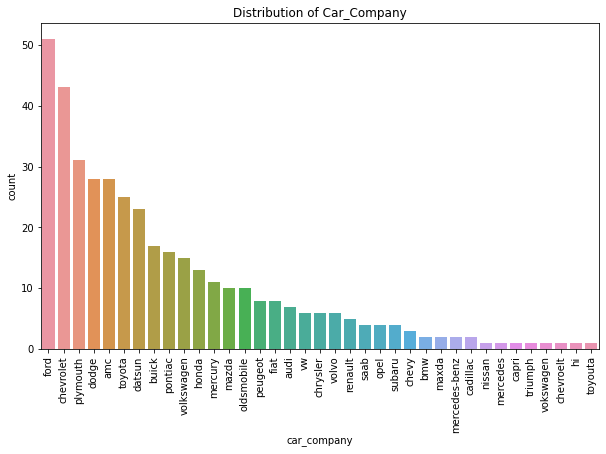

In [42]:
plt.figure(figsize=(10,6));
sns.countplot(x=df_cat["car_company"],order=df_cat["car_company"].value_counts().index);
plt.title("Distribution of Car_Company")
plt.xticks(rotation=90);

the distribution of car_company is not uniform and most of the proportion is covered by top 20 car companies. Whereas ford and chevrolet alone comprises of around 23% (almost a quater).

#### Conclusion
- Every categorical attribute except model_year is highly imbalanced and far from uniform distribution. In all cases most of the data is comprised of top few categories.
- Although model_year is not perfectly uniform but we can think it as uniform-like distribution. This is a digestible assumption for two reasons, first we can clearly see in plot that indeed the distribution is uniform-like and also this is not the entire population but a sample of it so for its population it may converge to uniform which may be the true population distribution



In [59]:
combos=itertools.combinations(["cyl","origin","mpg_level"],2)

In [60]:
x=list(combos)

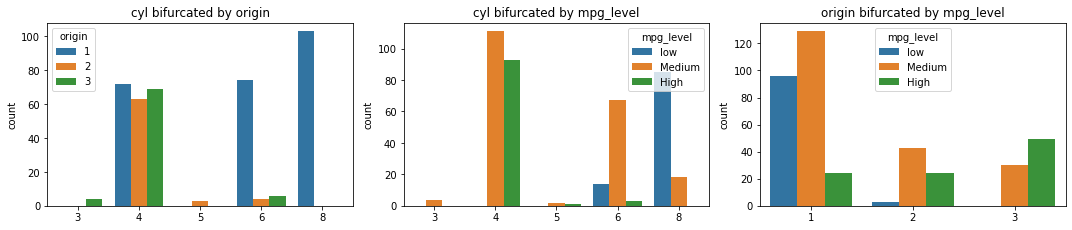

In [61]:
plt.figure(1,figsize=(15,6))
i=0
for pair in x :
    i+=1
    ax = plt.subplot(2,3,i)
    sns.countplot(x=pair[0], hue=pair[1], data=df_cat,ax=ax)
    ax.set_xlabel(None)
    ax.set_title(f'{pair[0]} bifurcated by {pair[1]}')
    plt.tight_layout()
   

   

- cylinders bigurcated by origin
  - Origin 3 is the only origin with vehicles having 3 cylinders.
  - Origin 2 is the only origin with vehicles having 5 cylinders.
  - Origin 1 is the only origin with vehicles having 8 cylinders.
  - All origins has 4 cylinder vehicles and in almost equal proportion, also because 4 is dominating in cylinders.
  - All origins has 6 cylinder vehicles but dominated by origin 1 due the fact that it is dominating in origin.

- cylinders bigurcated by mpg_level
  - 4 cylinder vehicle have  mileage ranging from medium to high
  - Vehicles with low mpg_level has either 6 or 8 cylinders and most of them has 8 cylinders
  - Almost all vehicles with high mpg_level has 4 cylinders and with very few (less than 5) has 5-6 cylinders.
  - Most vehicles with medium mpg_level has 4,6 & 8 cylinders. This is due to the fact that most of the vehicles has       these number of cylinders as we inspected in cylinder distribution earlier.
  
- origin bifurcated by mpg_level
  - Origin 1 doesn't have any vehicle with low mpg_level whereas origin 2 has negligible vehicles with low mpg_level       and almost all vehicles that has low mpg_level are from origin 1.
  - Origin 3 has the most vehicles with high mpg_level.
  - Origin 1 has the most vehicles with medium mpg_level (again due to the fact that most vehicles belongs to origin 1).
  

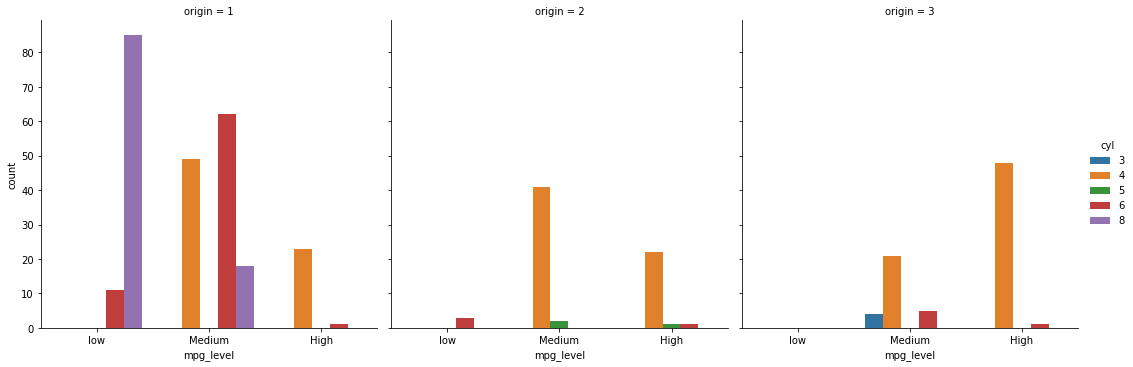

In [62]:
# Let's analyse mpg_level with cylinders bifurcated by origin.
sns.catplot(x='mpg_level', hue='cyl', col='origin', data=df_cat, kind='count')
plt.show()

- Most of the vehicles of origin 1 has either low mileage or medium mileage.
- Origin 1 is manufacturing vehicles with mostly 4,6 and 8 cylinders
- Origin 3 has no vehicle with low mpg levels
- Almost every vehicle in Origin 2 has 4 cylinders and most of them are medium or high

#### Conclusion
- Origin 3 is leading in case of mpg level with most of it's vehicles having high mpg_level. It has more than twice vehicles with high mpg compared to other origins.
- It seems like as number of cylinders increases mpg decreases generally.



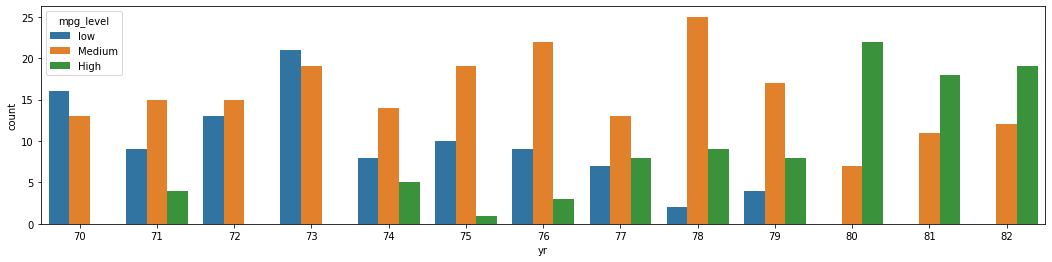

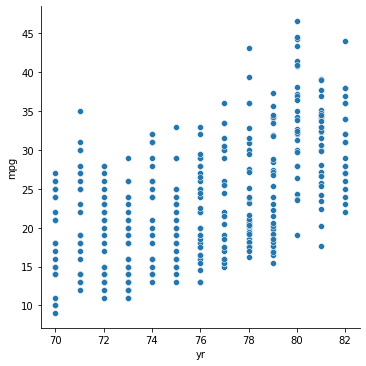

In [63]:
#Let's analyse model_year

fig = plt.figure(1, (18,4))
sns.countplot(x='yr', hue='mpg_level', data=df_cat)
sns.relplot(x='yr', y='mpg', data=cData)
plt.show()



- As year progresses manufacturing of low mpg car decreases and eventually stopped after 79.
- As year progresses manufacturing of high mpg car increases and infact after 79 their manufacturing was 1.5-2 times as compared to vehicles with medium mpg.
- Throughout the years there is no significant change in manufacturing of vehicles with medium mpg and infact from 74-79 their manufacturing was more than the sum of remaining two.
- From the scatter plot we can clearly see an upward linear trend i.e., as year progress mpg increases.


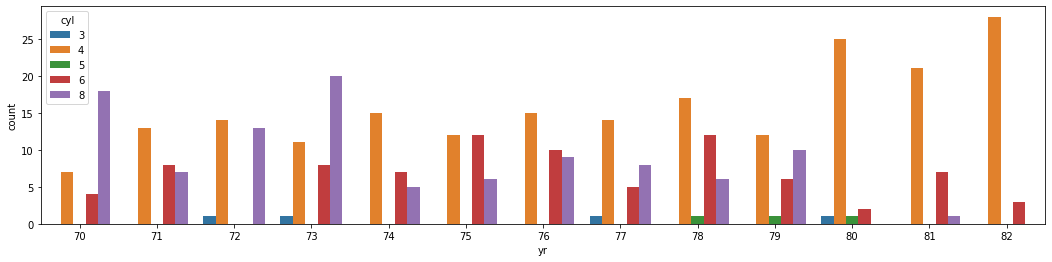

In [64]:
fig = plt.figure(1, (18,4))
sns.countplot(x='yr', hue='cyl', data=df_cat)
plt.show()

- As the year progresses vehicles with more cylinders (8 & 6) decreases significantly.
- As the year progresses vehicles with less cylinders increases.
- One important thing to be noticed that throughout the years vehicles with 4 cylinders have significant proportion and infact in the 80's most of the vehicles has 4 cylinders.


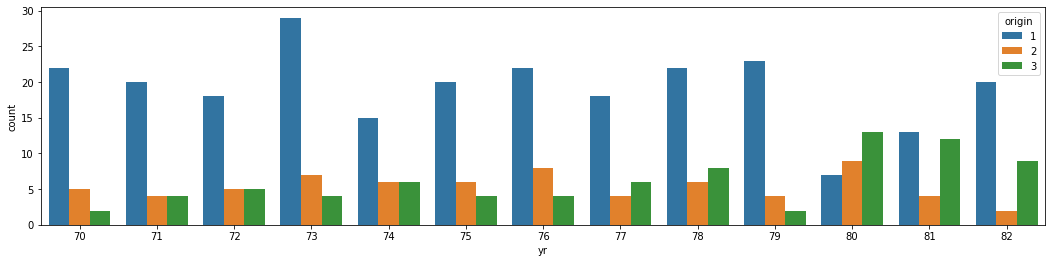

In [65]:
fig = plt.figure(1, (18,4))
sns.countplot(x='yr', hue='origin', data=df_cat)
plt.show()

- In the starting year manufacturing in origin 1 is dominated compeletely.
- As the year progresses origin 2 and origin 3 started manufacturing more vehicles. Infact in the year 80 both origin 2 and origin 3 manufactured more than origin 1. This may be due to something because throught the years origin 1 dominates and suddenly there is a considerable decrease in their manufacturing. 
- Initially origin 2 manufactures more vehicle then origin 3 but then origin 3 exceeds it after 76.


### Visualising Numerical Columns

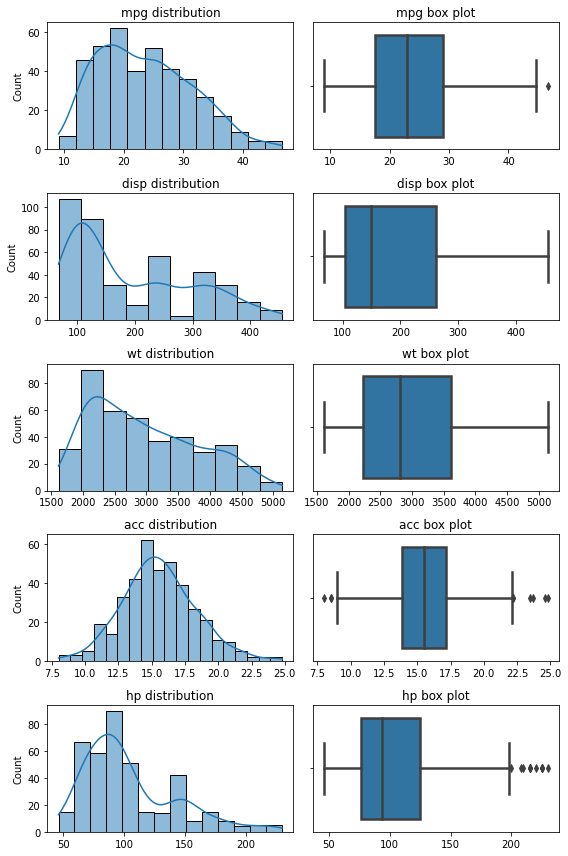

In [73]:
rows = len(numcols)
cols = 2
fig = plt.figure(figsize=(8,12))
i = 0
for col in numcols:    
    i += 1
    ax1 = plt.subplot(rows,cols,i)
    sns.histplot(x=df_num[col],kde=True)
    ax1.set_xlabel(None)
    ax1.set_title(f'{col} distribution')
    plt.tight_layout()

    i += 1
    ax2 = plt.subplot(rows,cols,i)
    sns.boxplot(x=df_num[col], orient='h', linewidth=2.5)
    ax2.set_xlabel(None)
    ax2.set_title(f'{col} box plot')
    plt.tight_layout()

- mpg Acceleration and horsepower have outliers
- mpg and acceleration are fairly normally distributed
- Displacement, weight and hp are right skewed,maybe log-normal


Text(0, 0.5, '')

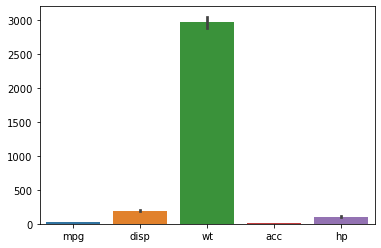

In [74]:
plt.figure()
sns.barplot(x="variable",y="value",data=pd.melt(df_num))
plt.xlabel(None)
plt.ylabel(None)


- see data is not scaled properly, we need to scale it for modelling but works fine for analysis.

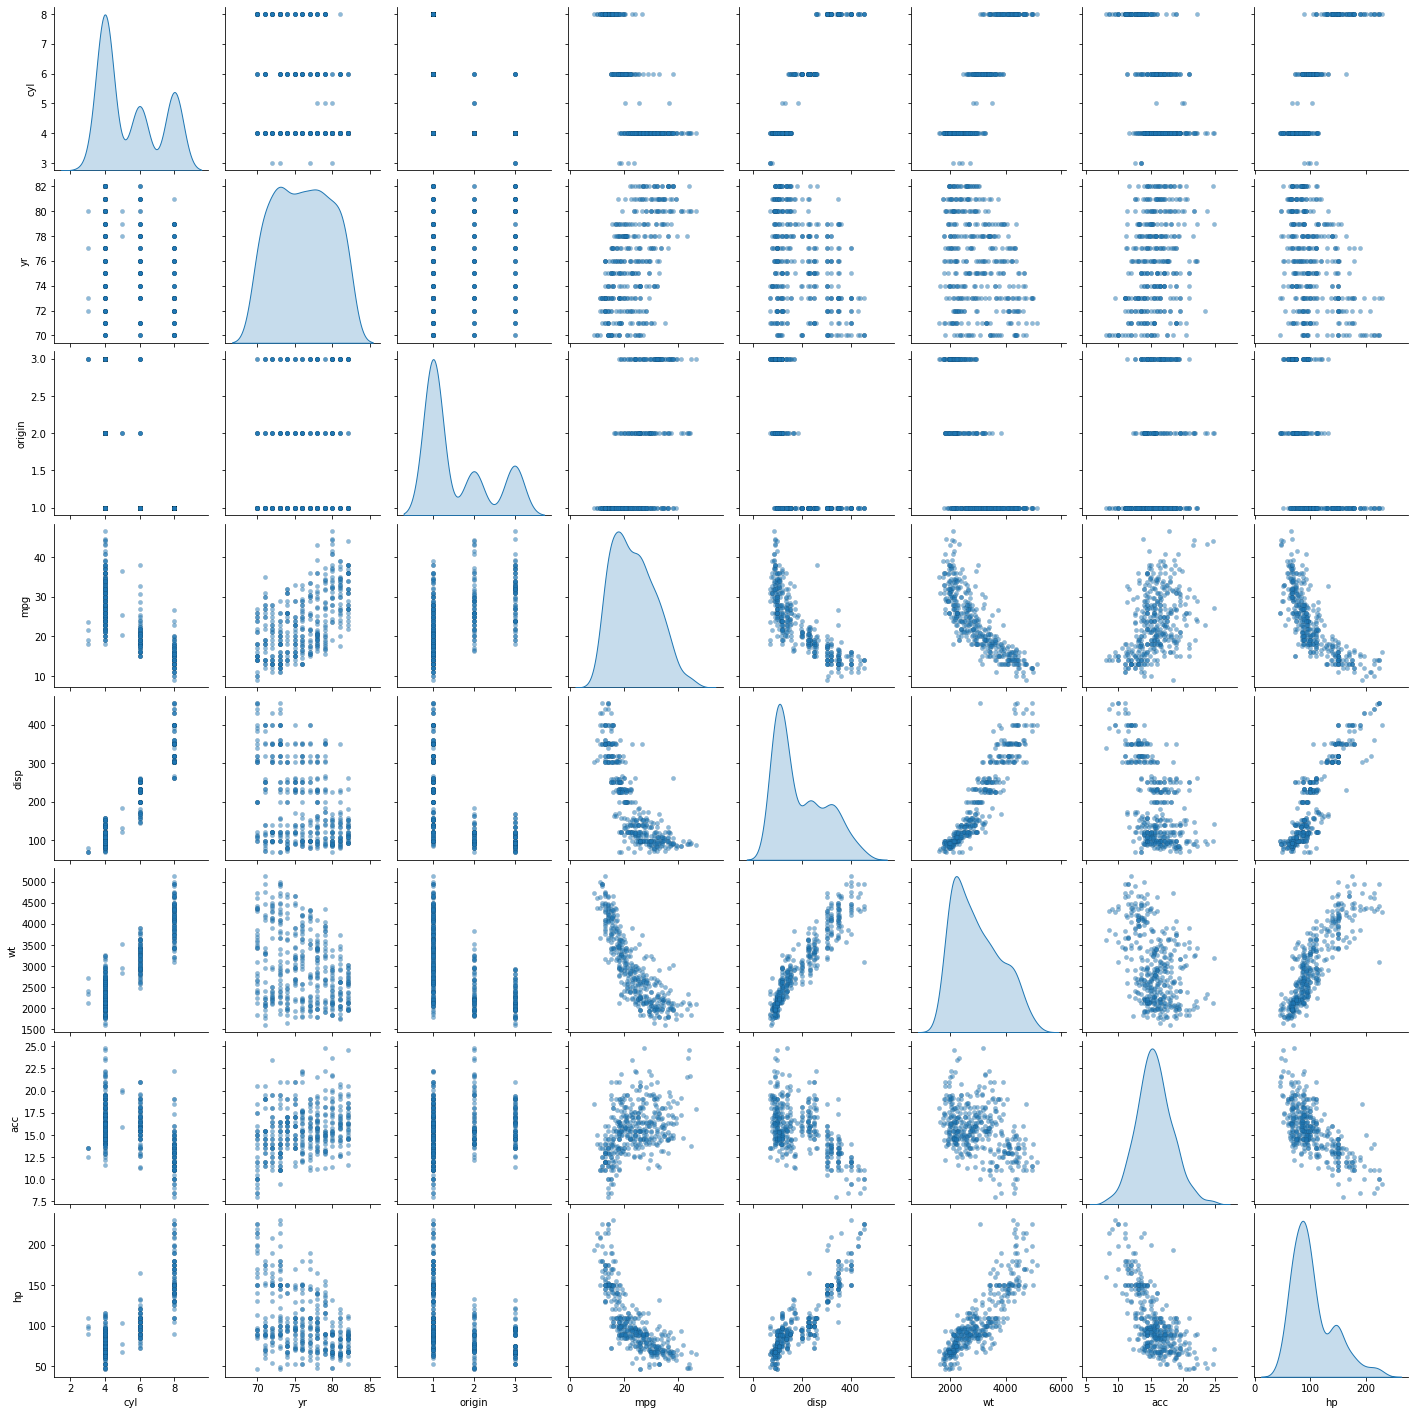

In [601]:
sns.pairplot(data=cData,diag_kind='kde',
             plot_kws=dict(s=20, edgecolor="k", linewidth=0.1, alpha=0.5),
             diag_kws=dict(shade=True))

- vehicles with high horsepower have low mileage
- vehicles with high horsepower have high displacement
- weight and horsepower have positive correlation,vehicles with high horsepower have more weight
- as mpg increases displacement, horsepower & weight decreases but acceleration increases.
- as weight increases displacement increases but acceleration decreases.
- as acceleration increases displacement decreases.

In [70]:
combos=itertools.combinations(['mpg', 'disp', 'wt', 'acc', 'hp'],2)
x=list(combos)

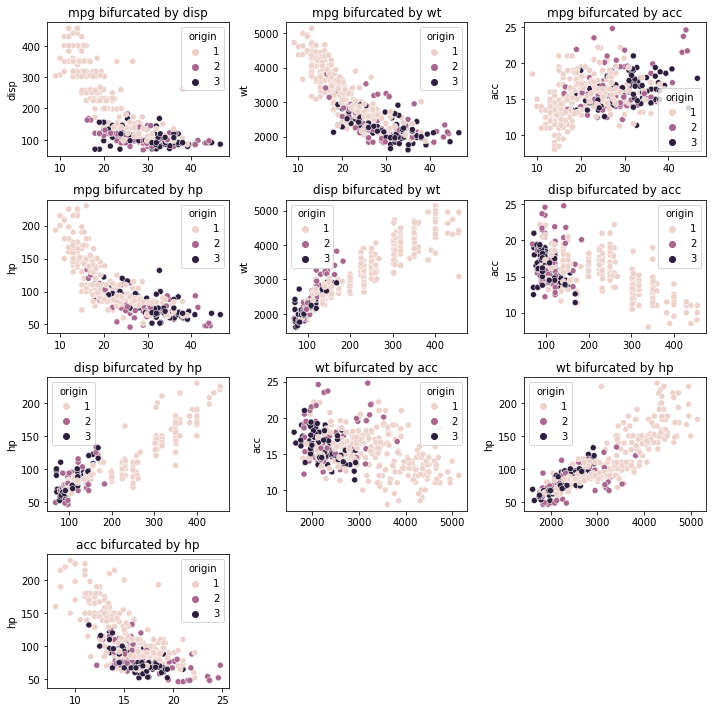

In [71]:

plt.figure(1,figsize=(10,10))
i=0
for pair in x :
    i+=1
    ax = plt.subplot(4,3,i)
    sns.scatterplot(x=pair[0], y=pair[1],data=cData,hue='origin',ax=ax)
    ax.set_xlabel(None)
    ax.set_title(f'{pair[0]} bifurcated by {pair[1]}')
    plt.tight_layout()

- in every origin there is a positive relation between horsepower and weight
- in every origin there is a negative relation between horsepower and acceleration
- in every origin there is a positive relation between horsepower and displacement
- in every origin there is a negative relation between weight and mpg and horsepower and mpg and displacement and mpg
- in origin 1 there is a negative relation between displacement and acceleration

variation of numerical features with cylinders


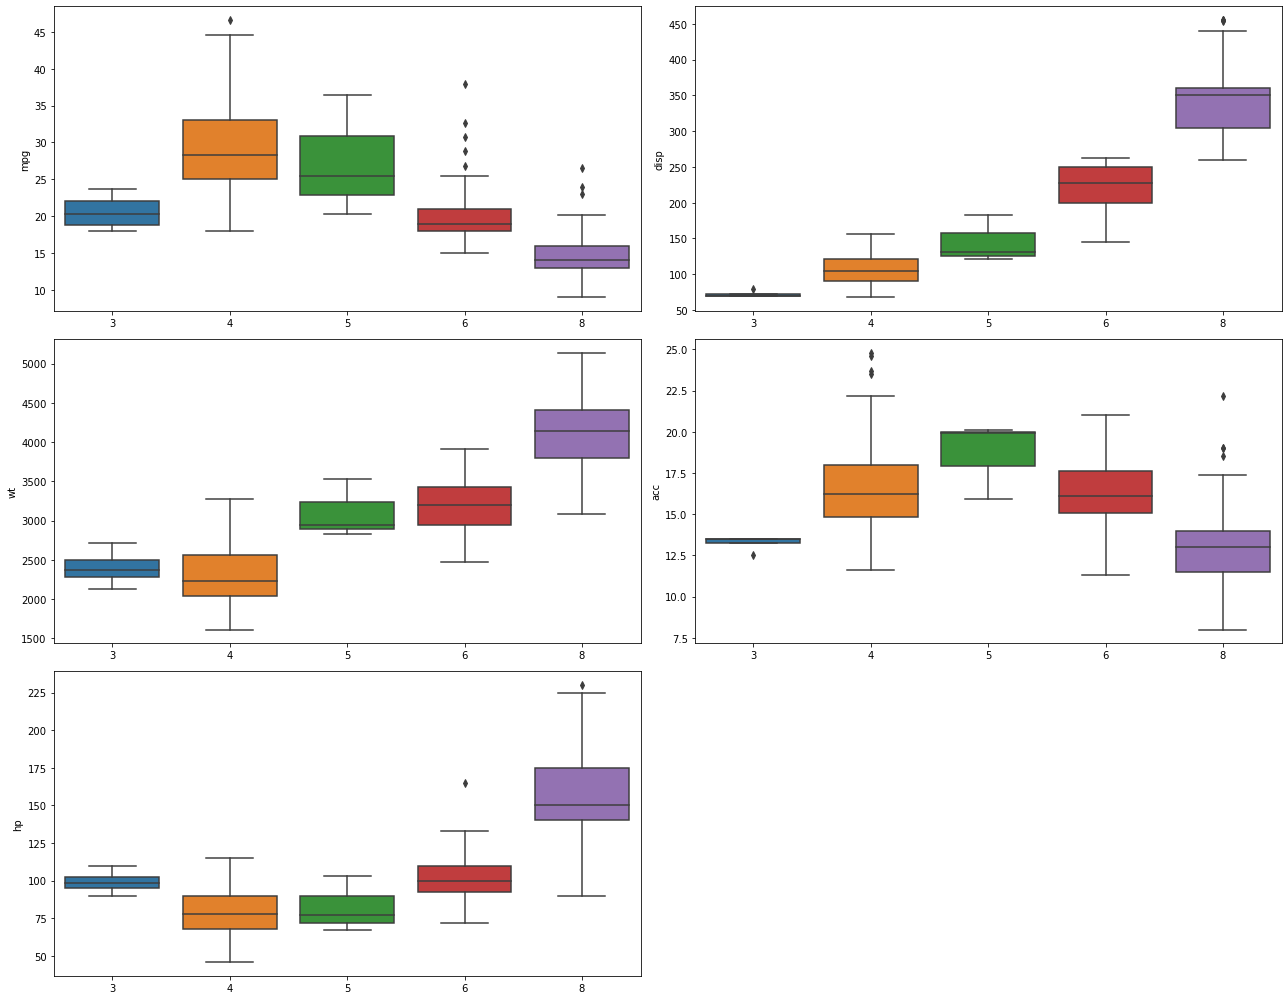

In [72]:
print('variation of numerical features with cylinders')

fig = plt.figure(1, (18, 14))

for i,col in enumerate(numcols):
    ax = plt.subplot(3, 2, i+1)
    sns.boxplot(x='cyl', y=col, data=cData)
    ax.set_xlabel(None)
    plt.tight_layout()

- as cylinders increases from 3 to 4 mpg also increases but on further increasing the cylinders mpg starts decreasing.
- as the number of cylinders are increasing the displacement is also increasing
- as cylinders increases from 3 to 5 horsepower decreases but on further increasing the cylinders it starts increasing.
- on increasing cylinders vehicle's weight increases on average (very obvious).
- as cylinders increases from 3 to 5 vehicle's acceleration also increases but on further increasing the cylinders it starts decreasing(maybe due to the fact that vehicles with more cylinders have more weight and hence less acceleration).

variation of numerical features with yr


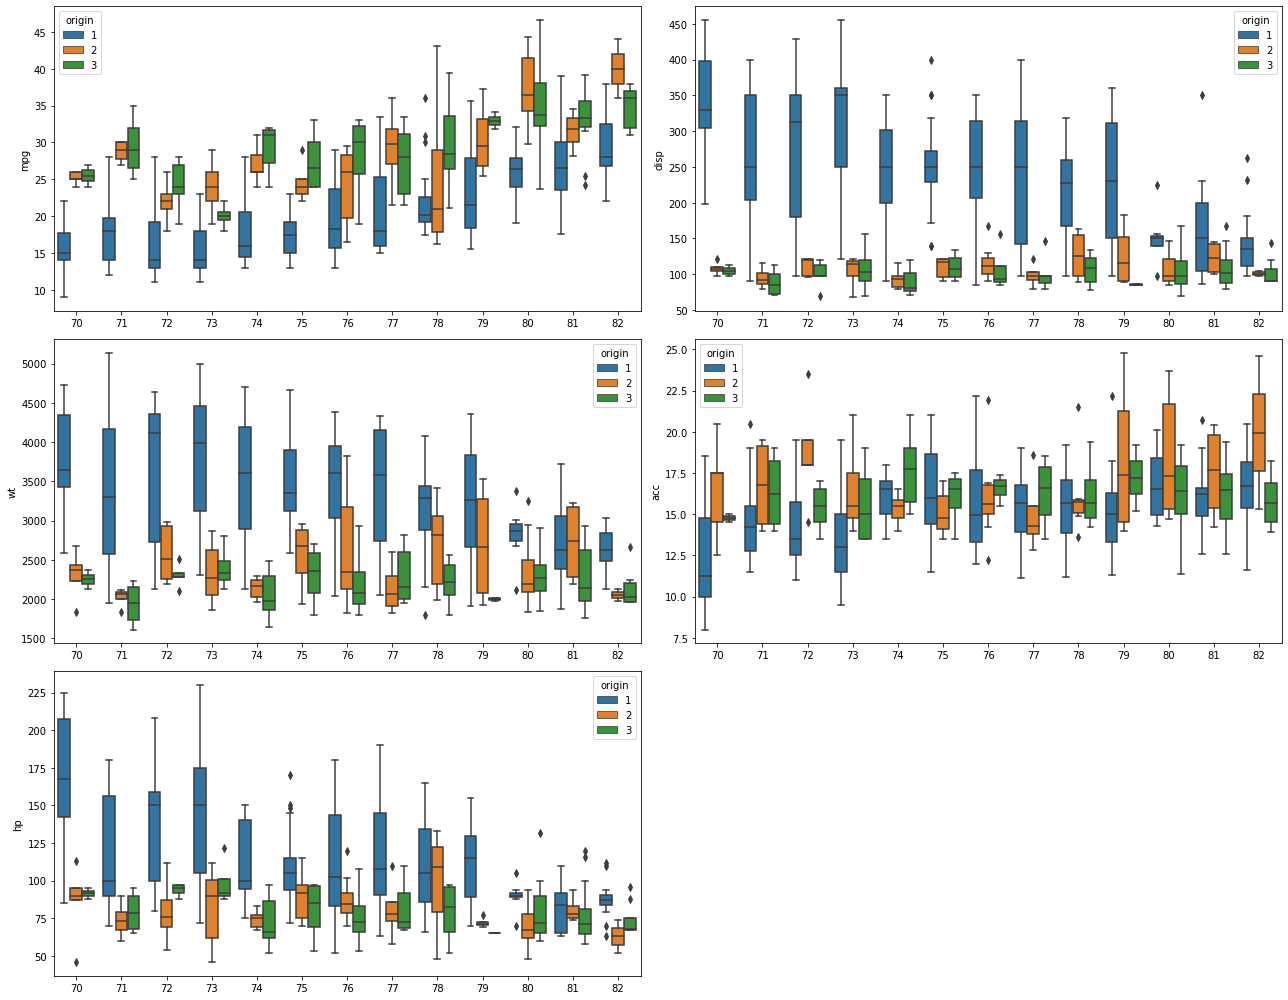

In [75]:
print('variation of numerical features with yr')

fig = plt.figure(1, (18, 14))

for i,col in enumerate(numcols):
    ax = plt.subplot(3, 2, i+1)
    sns.boxplot(x='yr', y=col, data=cData,hue="origin")
    ax.set_xlabel(None)
    plt.tight_layout()

- as year progresses there is an increase in mpg across all origins(this we already observed in analysis on categorical data).
- as year progresses there is a slight decrease in displacement, horsepower & weight of the vehicles belonging to origin 1 but there is no significant change in origin 2 & origin 3.
- throughout the years acceleration remains relatively the same across all origins


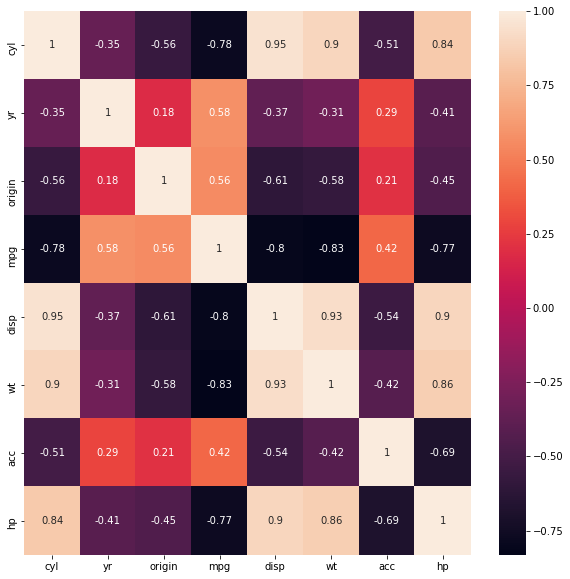

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(cData.corr(),annot=True)

- So all numerical attributes are related with each other.


In [45]:
origin = pd.crosstab(df_cat["origin"], df_cat["mpg_level"])
cyl=pd.crosstab(df_cat["cyl"], df_cat["mpg_level"])
yr=pd.crosstab(df_cat["yr"], df_cat["mpg_level"])


## Hypothesis Testing
### Testing the independence of categorical Features with Target Variable (Chi Square Test for independence)
     - Null Hypothesis:  There is no relationship between Feature and target variable 
     - Alternate Hypothesis: There is a significant relationship between Feature and target variable 

In [46]:
crosstab=[origin,cyl,yr]
alpha=0.05
for tab, col in [(crosstab[0],"origin"),(crosstab[1],"cyl"),(crosstab[2],"yr")]:
    stats,pval,dof,expected_values=chi2_contingency(tab)
    if pval<alpha:
        print("Rejected H0 under significance level {} {} & mpg_level are dependent".format(alpha,col))
    else:
        print("Fail to reject H0 due to lack of evidence under significance level {} {} & mpg_level are are independent".format(alphacol))

Rejected H0 under significance level 0.05 origin & mpg_level are dependent
Rejected H0 under significance level 0.05 cyl & mpg_level are dependent
Rejected H0 under significance level 0.05 yr & mpg_level are dependent


In [47]:
#Is the distribution of bmi across women with no children, one child and two children, the same
#h0:the distribution of bmi across women with no children, one child and two children, the same
#h1:the distribution of bmi across women with no children, one child and two children, is not  same
mpg_cyl3=cData[(cData["cyl"]==3)]["mpg"]
mpg_cyl4=cData[(cData["cyl"]==4)]["mpg"]
mpg_cyl5=cData[(cData["cyl"]==5)]["mpg"]
mpg_cyl6=cData[(cData["cyl"]==6)]["mpg"]
mpg_cyl8=cData[(cData["cyl"]==8)]["mpg"]               

stats, p_val=f_oneway(mpg_cyl3,mpg_cyl4,mpg_cyl5,mpg_cyl6,mpg_cyl8)
if p_val<0.05:
    print("RESULT:the distribution of mpg across different categories of cylinders is not  same")
else:
    print("RESULT:the distribution of mpg across different categories of cylinders is  same")

RESULT:the distribution of mpg across different categories of cylinders is not  same


In [48]:
mpg_origin1=cData[(cData["origin"]==1)]["mpg"]
mpg_origin2=cData[(cData["origin"]==2)]["mpg"]
mpg_origin3=cData[(cData["origin"]==3)]["mpg"]
            

stats, p_val=f_oneway(mpg_origin1,mpg_origin2,mpg_origin3)
if p_val<0.05:
    print("RESULT:the distribution of mpg across different categories of origin is not  same")
else:
    print("RESULT:the distribution of mpg across different categories of origin is  same")

RESULT:the distribution of mpg across different categories of origin is not  same


### Statistical Tests for Numerical Attributes

### Visual Normality Checks

1.  We will visually check for normality using 
    - Quantile-Quantile plot

2. Statistical Normality Tests
    - Shapiro-Wilk Test (only for gaussian distribution)

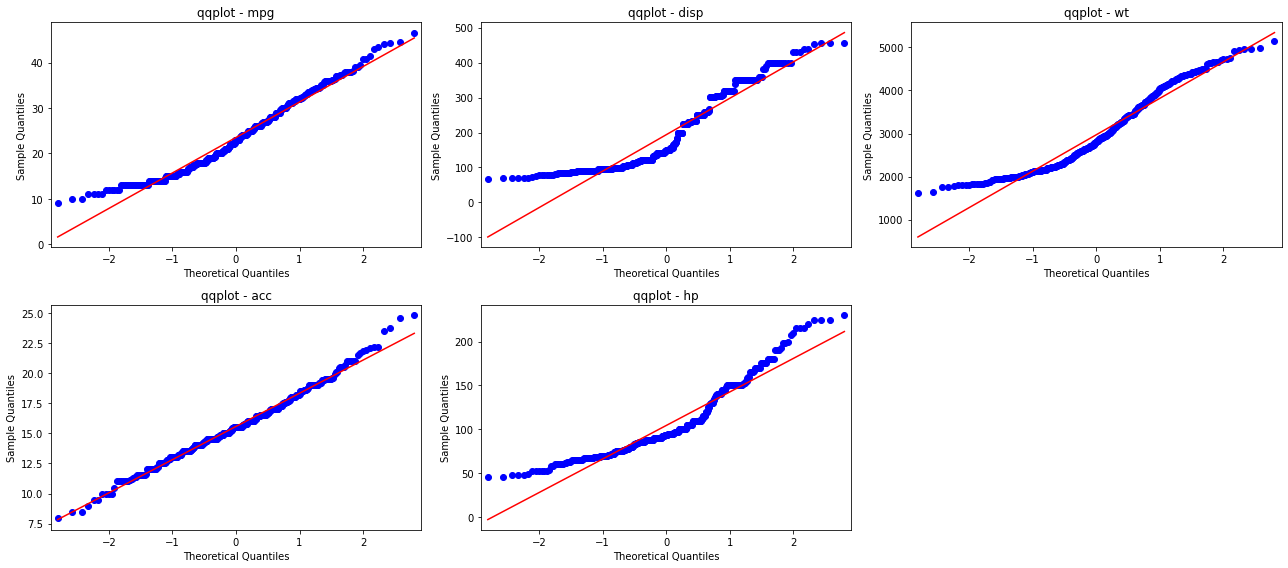

In [49]:
# quantile-quantile plots on original data
fig = plt.figure(1, (18,8))

for i,num in enumerate(numcols):
    ax = plt.subplot(2,3,i+1)
    sm.qqplot(cData[num], line= 's', ax=ax)
    ax.set_title(f'qqplot - {num}')
    plt.tight_layout()

- mpg and acceleration appear quite normal
- weight is also almost normally distributed

### Statistical Normality Tests

We will do hypothesis testing for the normality of numerical attributes using the shapiro wilk test.

   H0
: Data is drawn from normal distribution.        α=0.05

In [50]:
def shapiro_wilk_test(df, cols, alpha=0.05):
    # test the null hypothesis for columns given in `cols` of the dataframe `df` under significance level `alpha`.
    for col in cols:
        _,p_val = shapiro(df[col])
        if p_val <= alpha:
            print(f'''\nRejected H0 under significance level {alpha}\n{col} doesn't seems to be normally distributed''')
        else:
            print(f'''\nFail to reject H0 due to lack of evidence under significance level {alpha}\n{col} seem to be normally distributed''')

In [51]:
shapiro_wilk_test(cData, numcols)


Rejected H0 under significance level 0.05
mpg doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
disp doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
wt doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
acc doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
hp doesn't seems to be normally distributed


### Testing the independence of Numerical Columns Features with Target Variable(Independent t-test)

    Null Hypothesis: There is no significant difference in feature Variable and Target variable
    Alternate Hypothesis:There is significant difference in feature Variable and Target variable



In [52]:
for col in numcols:
    if col =="mpg":
        continue
    stats,p_value =ttest_ind(cData[col],cData["mpg"],equal_var=False)
    if p_value<0.05:
        print("There is significant difference in {} and mpg".format(col))
    else:
        print("There is no significant difference in {} mpg".format(col))


There is significant difference in disp and mpg
There is significant difference in wt and mpg
There is significant difference in acc and mpg
There is significant difference in hp and mpg


We can also check for multi-collinearity using the variance inflation factor.A variable/feature affected by multi-collinearity will have a value greater than 5 when we print out the series from the variance inflation factor

## Data PreProcessing

In [53]:
#dropping car_name columns from original data
cData.drop("car_name",axis=1,inplace=True)
cData["mpg_level"]=df_cat["mpg_level"]

In [447]:
car_data=cData.copy()

In [448]:
car_data

,cyl,yr,origin,mpg,disp,wt,acc,hp,mpg_level
0,8,70,1,18.0,307.0,3504,12.0,130.0,Medium
1,8,70,1,15.0,350.0,3693,11.5,165.0,low
2,8,70,1,18.0,318.0,3436,11.0,150.0,Medium
3,8,70,1,16.0,304.0,3433,12.0,150.0,low
4,8,70,1,17.0,302.0,3449,10.5,140.0,low
...,...,...,...,...,...,...,...,...,...
393,4,82,1,27.0,140.0,2790,15.6,86.0,Medium
394,4,82,2,44.0,97.0,2130,24.6,52.0,High
395,4,82,1,32.0,135.0,2295,11.6,84.0,High
396,4,82,1,28.0,120.0,2625,18.6,79.0,Medium


- Deleting correlated features

In [449]:
correlatedfeatures = set()
correlation_matrix = car_data.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90 and (correlation_matrix.columns[j] not in correlatedfeatures):
            colname = correlation_matrix.columns[i]
            correlatedfeatures.add(colname)

In [450]:
print("correlated features",correlatedfeatures)
car_data.drop(labels=correlatedfeatures, axis=1, inplace=True)

correlated features {'disp'}


- hp column has outliers which is visible as right skew in its kde plot.
- acc feature also have outliers
- doing log transformation on hp column to remove the skew
- will remove outliers if after log transformation it is necessary

In [451]:
car_data["hp"]=np.log(car_data["hp"])

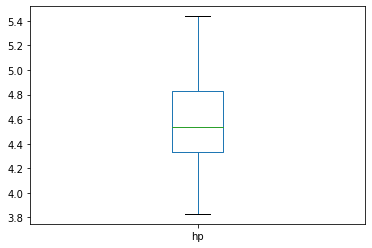

In [452]:
car_data["hp"].plot.box()

- hp has no outliers left
- cant do lof transform on acc feature coz it is already normally disributed.
- will delete outliers from acc column

In [453]:
scaler = StandardScaler()
encoder=LabelEncoder()
# Scale and Encode Separate Columns

car_data = pd.get_dummies(car_data,columns=['mpg_level'])
car_data[["cyl","yr","origin"]]=car_data[["cyl","yr","origin"]].apply(lambda x: encoder.fit_transform(x))
car_data[["mpg","wt","acc","hp"]]=scaler.fit_transform(car_data[["mpg","wt","acc","hp"]])

In [454]:
car_data.drop("acc",axis=1,inplace=True)

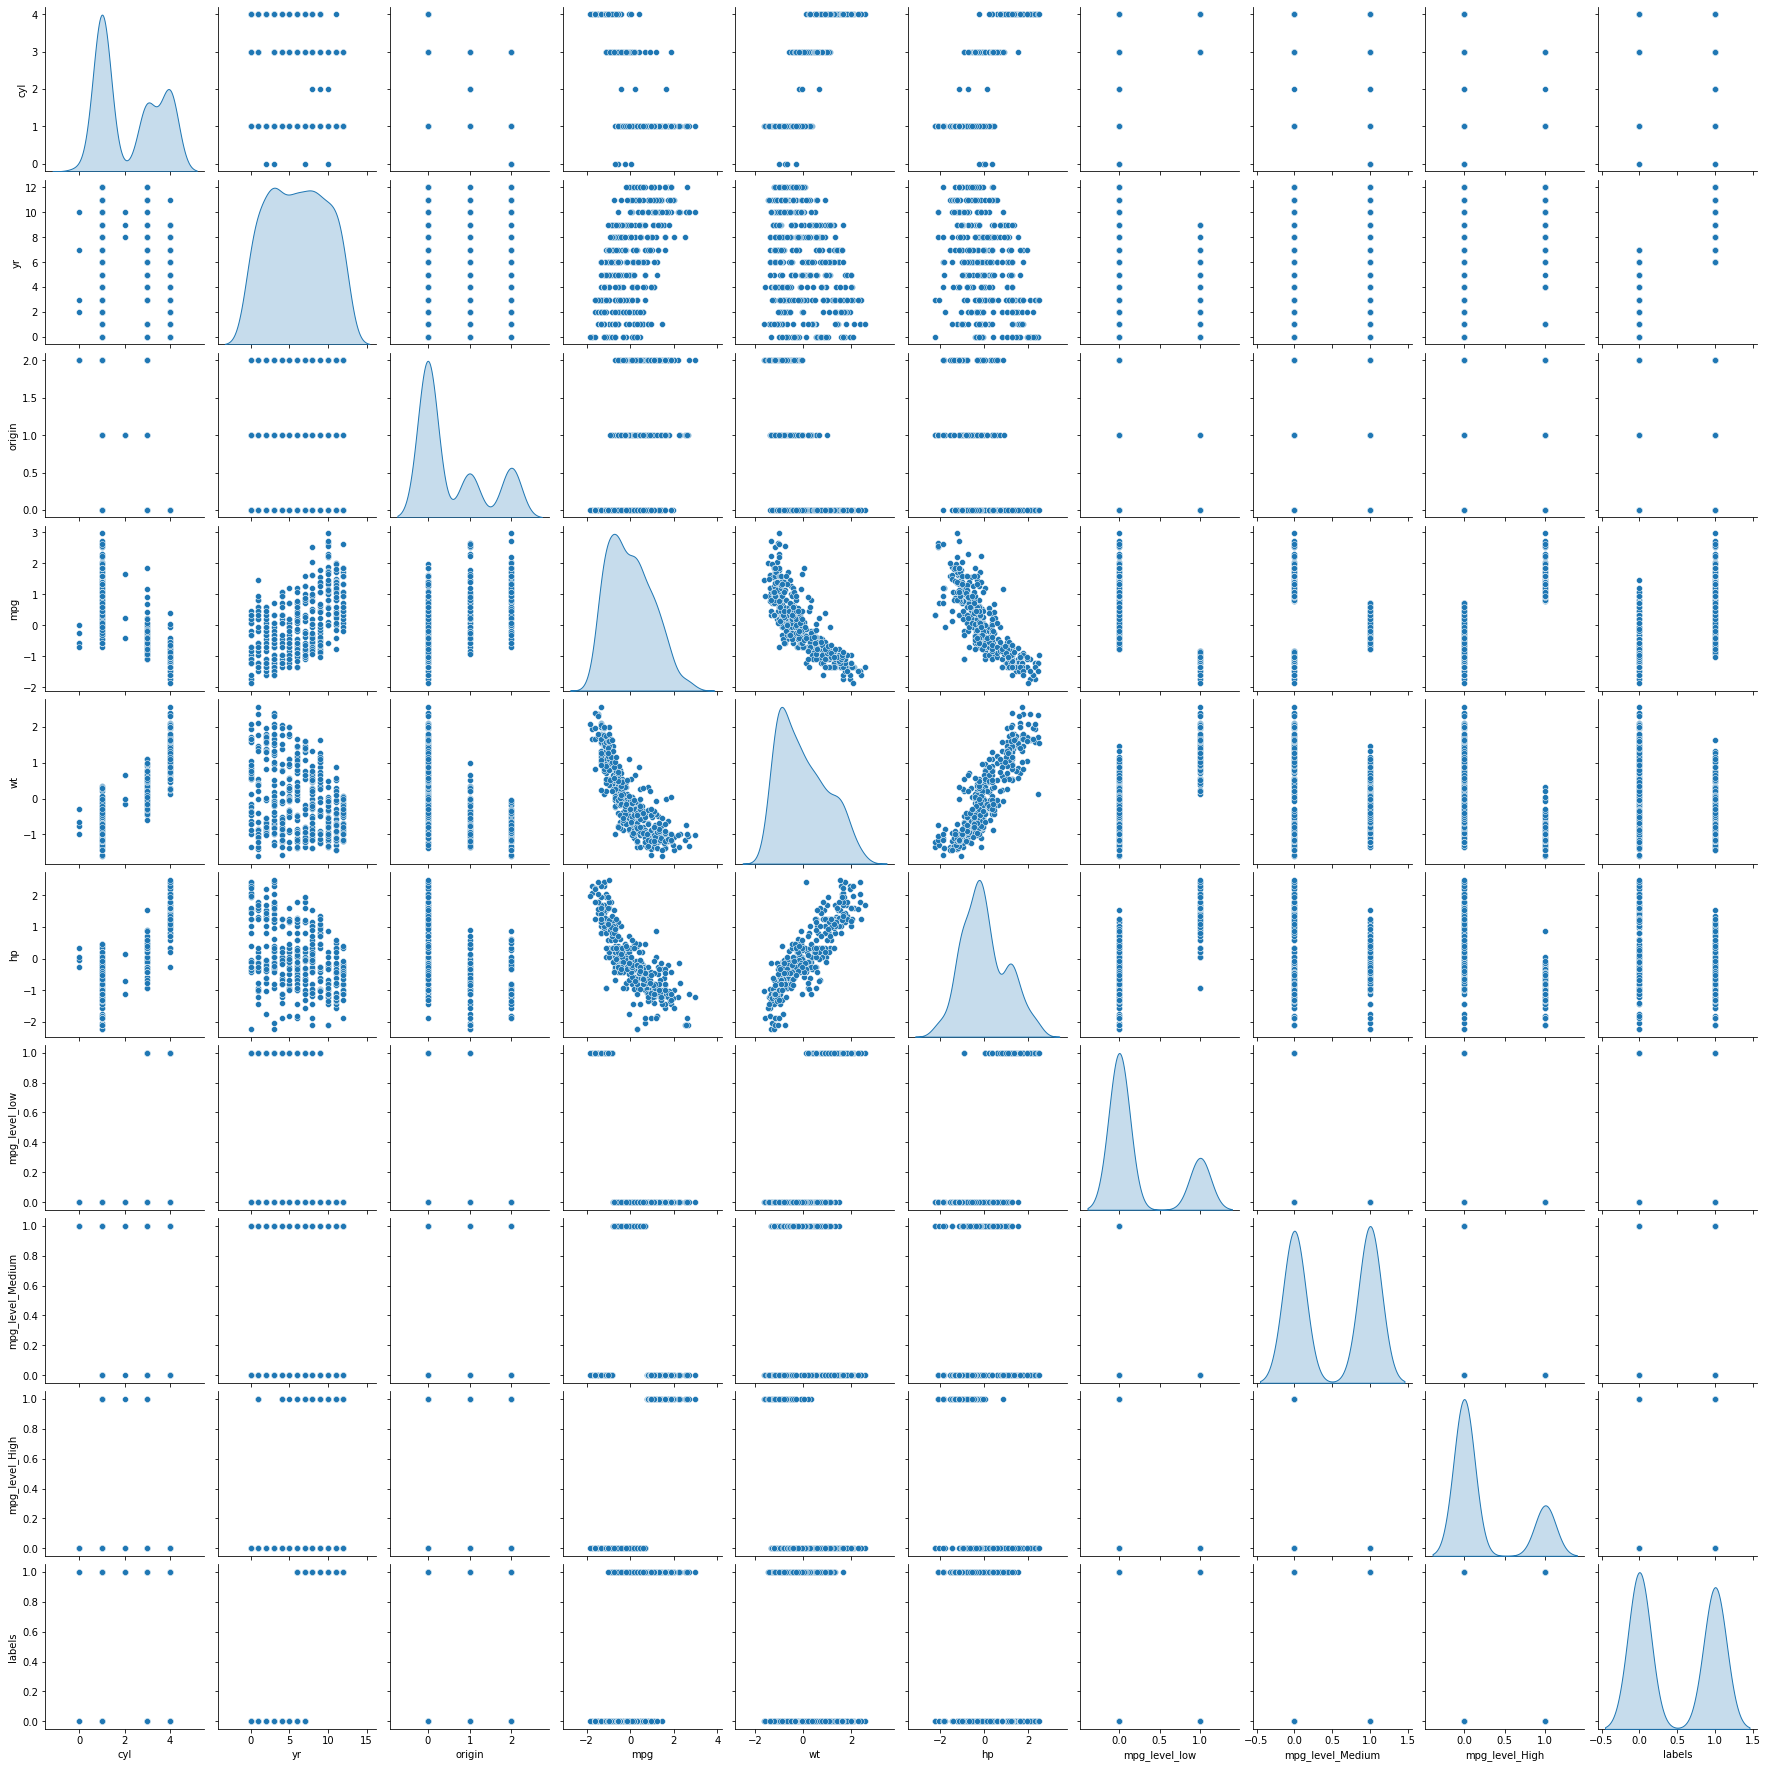

In [520]:
sns.pairplot(car_data,diag_kind="kde")

- After dropping correlated features and insignificant features the pair plot above shows clear two clustes


## Clustering method 1: KMeans

Cluster data using the KMeans algorithm and visualize the results


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


Text(0.5, 1.0, 'Selecting k with the elbow Method')

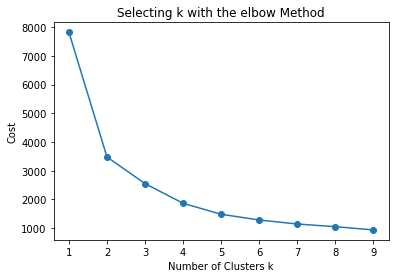

In [456]:
#choose optimal number of k
inertias=[]
for cluster in range(1,10):
    kmeans= KMeans(n_clusters=cluster,init='k-means++', n_init=10, random_state=1)
    cluster_labels=kmeans.fit_predict(car_data)
    inertias.append(kmeans.inertia_)
    print('Cluster initiation: {}'.format(cluster))

# Converting the results into a dataframe and plotting them
df_clusters = pd.DataFrame({'Cluster':range(1, 10), 'Inertia':inertias}) 
plt.plot
plt.plot(df_clusters["Cluster"],df_clusters["Inertia"],marker="o")
plt.xlabel("Number of Clusters k")
plt.ylabel("Cost")
plt.title("Selecting k with the elbow Method")

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.This means we should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. 

In [457]:
#selecting k =2 and fitting the model
from sklearn.metrics import silhouette_score
kmeans_2= KMeans(n_clusters=2,init='k-means++', n_init=10, random_state=1)
    
labels_2=kmeans_2.fit_predict(car_data)
score = silhouette_score(car_data, kmeans_2.labels_, metric='euclidean')
print("silhouette score for two Clusters",score)

silhouette score for two Clusters 0.4443146299497872


In [458]:
#selecting k =3 and fitting the model
from sklearn.metrics import silhouette_score
kmeans_3= KMeans(n_clusters=3,init='k-means++', n_init=10, random_state=1)
    
labels_3=kmeans_3.fit_predict(car_data)
score = silhouette_score(car_data, kmeans_3.labels_, metric='euclidean')
print("silhouette score for three Clusters",score)

silhouette score for three Clusters 0.35242601229347353


- Thus going for two clusters. the higher the silhoutte the good the clustering
- number of clusters as 2 shows maximum silhoutte score

In [459]:
car_data["labels"]=labels_2
car_data

,cyl,yr,origin,mpg,wt,hp,mpg_level_low,mpg_level_Medium,mpg_level_High,labels
0,4,0,0,-0.706439,0.630870,0.823608,0,1,0,0
1,4,0,0,-1.090751,0.854333,1.523992,1,0,0,0
2,4,0,0,-0.706439,0.550470,1.243998,0,1,0,0
3,4,0,0,-0.962647,0.546923,1.243998,1,0,0,0
4,4,0,0,-0.834543,0.565841,1.041316,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
393,1,12,0,0.446497,-0.213324,-0.390219,0,1,0,1
394,1,12,1,2.624265,-0.993671,-1.868196,0,0,1,1
395,1,12,0,1.087017,-0.798585,-0.459345,0,0,1,1
396,1,12,0,0.574601,-0.408411,-0.639630,0,1,0,1


In [442]:
car_data.columns

Index(['cyl', 'yr', 'origin', 'mpg', 'wt', 'hp', 'mpg_level_low',
       'mpg_level_Medium', 'mpg_level_High', 'labels'],
      dtype='object')

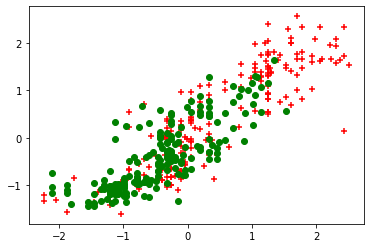

In [460]:
#viewing the cluster formation
for i in range(0,car_data.shape[0]):
    if kmeans_2.labels_[i]==0:
        c1=plt.scatter(car_data.iloc[i,5],car_data.iloc[i,4],c="r",marker="+")
    elif kmeans_2.labels_[i]==1:
        c2=plt.scatter(car_data.iloc[i,5],car_data.iloc[i,4],c="g",marker="o")   


In [461]:
cluster1=car_data[car_data["labels"]==0]
cluster1.shape


(209, 10)

In [462]:
cluster1.cyl.value_counts()

4    84
1    74
3    49
0     2
Name: cyl, dtype: int64

In [463]:
cluster2=car_data[car_data["labels"]==1]
cluster2.shape

(189, 10)

In [464]:
cluster2.cyl.value_counts()

1    130
3     35
4     19
2      3
0      2
Name: cyl, dtype: int64

In [467]:
cluster1_X=cluster1.drop(["mpg","labels"],axis=1)
cluster1_y=cluster1["mpg"]

cluster2_X=cluster2.drop(["mpg","labels"],axis=1)
cluster2_y=cluster2["mpg"]



In [468]:
X_train1,X_test1,y_train1,y_test1=train_test_split(cluster1_X,cluster1_y,test_size=.3,random_state=1)

In [469]:
reg1=LinearRegression()
reg1.fit(X_train1,y_train1)
y_pred1 = reg1.predict(X_test1)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(reg1.score(X_train1,y_train1)))
# score the model on the test set
print('Test score: {}\n'.format(reg1.score(X_test1,y_test1)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test1,y_pred1)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test1,y_pred1)))


Train score: 0.877801182115616

Test score: 0.8871687959057196

Overall model accuracy: 0.8871687959057196

Mean Squared Error: 0.05563523513375888


In [470]:
for idx,col in enumerate(cluster1_X.columns):
    print("the coefficients for {} is {}".format(col,reg1.coef_[idx]))

the coefficients for cyl is -0.06374457139659537
the coefficients for yr is 0.011392878075544642
the coefficients for origin is 0.08472204832360326
the coefficients for wt is -0.2883981591312228
the coefficients for hp is -0.09337655698770372
the coefficients for mpg_level_low is -0.3545307685055375
the coefficients for mpg_level_Medium is -0.16980257066366497
the coefficients for mpg_level_High is 0.5243333391692024


In [471]:
cluster1_X_ = sm.add_constant(cluster1_X)
model = sm.OLS(cluster1_y,cluster1_X_)
results = model.fit()

# MSE of the residuals
print(f"MSE: {results.mse_resid}")

# Output Results
results.summary()

MSE: 0.06184647039253965


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     217.5
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           3.87e-90
Time:                        03:39:34   Log-Likelihood:                -1.6456
No. Observations:                 209   AIC:                             19.29
Df Residuals:                     201   BIC:                             46.03
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0030      0.076     -0.039      0.969      -0.154       0.148
cyl                 -0.1023      0.034     -3.048      0.003      -0.168      -0.036
yr                   0.0176      0.010      1.842      0.067      -0.001       0.036
origin               0.0533      0.039      1.372      0.172      -0.023       0.130
wt                  -0.2778      0.048     -5.781      0.000      -0.373      -0.183
hp                  -0.0386      0.040     -0.968      0.334      -0.117       0.040
mpg_level_low       -0.4279      0.060     -7.093      0.000      -0.547      -0.309
mpg_level_Medium    -0.1666      0.033     -5.075      0.000      -0.231      -0.102
mpg_level_High       0.5915      0.083      7.116      0.000       0.428       0.755
==============================================================================
Omnibus:                       11.401   Durbin-Watson:                   1.401
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.337
Skew:                          -0.405   Prob(JB):                     0.000770
Kurtosis:                       3.995   Cond. No.                     9.30e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.13e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- for cluster 1 adjusted r-squared value is .879
- this means almost 88% of variance is explained by regression line
- from OLS summary it is evident that for this cluster only 
  - cyl ,wt and mpg_level_low,mpg_level_Medium,and mpg_level_high are significant

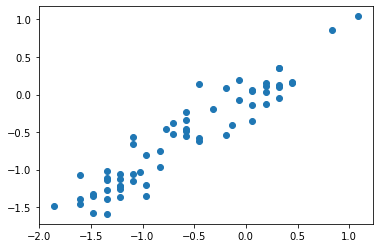

In [535]:
plt.scatter(list(y_test1), list(y_pred1))
plt.show()

In [472]:
X_train2,X_test2,y_train2,y_test2=train_test_split(cluster2_X,cluster2_y,test_size=.3,random_state=1)

In [473]:
reg2=LinearRegression()
reg2.fit(X_train2,y_train2)
y_pred2 = reg2.predict(X_test2)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(reg2.score(X_train2,y_train2)))
# score the model on the test set
print('Test score: {}\n'.format(reg2.score(X_test2,y_test2)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test2,y_pred2)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test2,y_pred2)))


Train score: 0.8481003538033671

Test score: 0.820095628636908

Overall model accuracy: 0.820095628636908

Mean Squared Error: 0.1522604276573835


In [474]:
for idx,col in enumerate(cluster2_X.columns):
    print("the coefficients for {} is {}".format(col,reg2.coef_[idx]))

the coefficients for cyl is -0.026167067429661687
the coefficients for yr is 0.09255765553876066
the coefficients for origin is -0.0023970811174652213
the coefficients for wt is -0.32456728203430096
the coefficients for hp is -0.2838523852817354
the coefficients for mpg_level_low is -0.3454904200429413
the coefficients for mpg_level_Medium is -0.20753249438147708
the coefficients for mpg_level_High is 0.5530229144244163


In [475]:
cluster2_X_ = sm.add_constant(cluster2_X)
model = sm.OLS(cluster2_y,cluster2_X_)
results = model.fit()

# MSE of the residuals
print(f"MSE: {results.mse_resid}")

# Output Results
results.summary()

MSE: 0.13434793140359003


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           5.85e-69
Time:                        03:40:01   Log-Likelihood:                -74.400
No. Observations:                 189   AIC:                             164.8
Df Residuals:                     181   BIC:                             190.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4219      0.151     -2.794      0.006      -0.720      -0.124
cyl                 -0.0134      0.046     -0.293      0.770      -0.103       0.077
yr                   0.0833      0.016      5.278      0.000       0.052       0.114
origin               0.0250      0.037      0.671      0.503      -0.048       0.098
wt                  -0.3599      0.090     -4.013      0.000      -0.537      -0.183
hp                  -0.2558      0.064     -4.026      0.000      -0.381      -0.130
mpg_level_low       -0.5334      0.124     -4.309      0.000      -0.778      -0.289
mpg_level_Medium    -0.3230      0.061     -5.303      0.000      -0.443      -0.203
mpg_level_High       0.4345      0.105      4.149      0.000       0.228       0.641
==============================================================================
Omnibus:                       20.316   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.599
Skew:                           0.688   Prob(JB):                     1.68e-06
Kurtosis:                       4.219   Cond. No.                     6.68e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.03e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- for cluster 2 adjusted r-squared value is .836
- this means almost 84% of variance is explained by regression line
- from OLS summary it is evident that for this cluster only 
  - wt ,hp,mpg_level_low,mpg_level_Medium,and mpg_level_high are significant

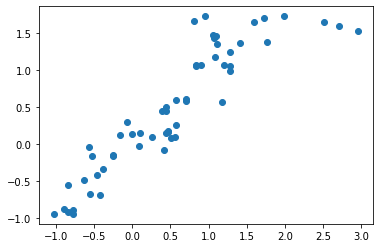

In [536]:
plt.scatter(list(y_test2), list(y_pred2))
plt.show()

## Clustering method 2: Hierarchical 

In [476]:
car_data_shc=car_data.copy()

In [477]:
car_data_shc.drop("labels",axis=1,inplace=True)

In [478]:
car_data_shc

,cyl,yr,origin,mpg,wt,hp,mpg_level_low,mpg_level_Medium,mpg_level_High
0,4,0,0,-0.706439,0.630870,0.823608,0,1,0
1,4,0,0,-1.090751,0.854333,1.523992,1,0,0
2,4,0,0,-0.706439,0.550470,1.243998,0,1,0
3,4,0,0,-0.962647,0.546923,1.243998,1,0,0
4,4,0,0,-0.834543,0.565841,1.041316,1,0,0
...,...,...,...,...,...,...,...,...,...
393,1,12,0,0.446497,-0.213324,-0.390219,0,1,0
394,1,12,1,2.624265,-0.993671,-1.868196,0,0,1
395,1,12,0,1.087017,-0.798585,-0.459345,0,0,1
396,1,12,0,0.574601,-0.408411,-0.639630,0,1,0


In [500]:
cluster_2=AgglomerativeClustering(n_clusters=2,affinity="euclidean",linkage="average")
labels_shc_2=cluster_2.fit_predict(car_data_shc)

In [501]:
silhouette_score(car_data_shc,cluster_2.labels_)

0.4254059156283082

In [498]:
cluster_3=AgglomerativeClustering(n_clusters=3,affinity="euclidean",linkage="average")
labels_shc_3=cluster_3.fit_predict(car_data_shc)

In [499]:
silhouette_score(car_data_shc,cluster_3.labels_)

0.36718437625886047

- Selecting numbers of clusters 2

In [502]:
car_data_shc["labels"]=labels_shc_2

In [504]:
cluster1_shc=car_data_shc[car_data_shc["labels"]==0]
cluster2_shc=car_data_shc[car_data_shc["labels"]==1]


In [505]:
cluster1_shc_X=cluster1_shc.drop(["mpg","labels"],axis=1)
cluster1_shc_y=cluster1_shc["mpg"]

cluster2_shc_X=cluster2_shc.drop(["mpg","labels"],axis=1)
cluster2_shc_y=cluster2_shc["mpg"]



In [506]:
X_train1_shc,X_test1_shc,y_train1_shc,y_test1_shc=train_test_split(cluster1_shc_X,cluster1_shc_y,test_size=.2,random_state=1)

In [507]:
shc_reg1=LinearRegression()
shc_reg1.fit(X_train1_shc,y_train1_shc)
shc_y_pred1 = shc_reg1.predict(X_test1_shc)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(shc_reg1.score(X_train1_shc,y_train1_shc)))
# score the model on the test set
print('Test score: {}\n'.format(shc_reg1.score(X_test1_shc,y_test1_shc)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test1_shc,shc_y_pred1)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test1_shc,shc_y_pred1)))

Train score: 0.8841107205956664

Test score: 0.9109549096666237

Overall model accuracy: 0.9109549096666237

Mean Squared Error: 0.05798587789495


In [533]:
for idx,col in enumerate(cluster1_shc_X.columns):
    print("the coefficients for {} is {}".format(col,shc_reg1.coef_[idx]))

the coefficients for cyl is -0.09505659673959999
the coefficients for yr is 0.01884938039735195
the coefficients for origin is 0.04643907071650919
the coefficients for wt is -0.30642612872499475
the coefficients for hp is -0.05386692087046228
the coefficients for mpg_level_low is -0.3758700870695765
the coefficients for mpg_level_Medium is -0.15664210783077473
the coefficients for mpg_level_High is 0.5325121949003474


In [508]:
cluster1_shc_X_ = sm.add_constant(cluster1_shc_X)
model = sm.OLS(cluster1_shc_y,cluster1_shc_X)
results = model.fit()

# MSE of the residuals
print(f"MSE: {results.mse_resid}")

# Output Results
results.summary()

MSE: 0.06450414929653579


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     233.5
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           1.33e-92
Time:                        03:43:49   Log-Likelihood:                -5.9936
No. Observations:                 208   AIC:                             27.99
Df Residuals:                     200   BIC:                             54.69
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
cyl                 -0.1089      0.033     -3.337      0.001      -0.173      -0.045
yr                   0.0250      0.010      2.425      0.016       0.005       0.045
origin               0.0456      0.036      1.260      0.209      -0.026       0.117
wt                  -0.3120      0.049     -6.337      0.000      -0.409      -0.215
hp                  -0.0432      0.041     -1.059      0.291      -0.124       0.037
mpg_level_low       -0.3779      0.107     -3.543      0.000      -0.588      -0.168
mpg_level_Medium    -0.1670      0.091     -1.839      0.067      -0.346       0.012
mpg_level_High       0.5158      0.138      3.738      0.000       0.244       0.788
==============================================================================
Omnibus:                       16.614   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.064
Skew:                          -0.560   Prob(JB):                     2.67e-05
Kurtosis:                       4.084   Cond. No.                         43.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- for cluster 1 adjusted r-squared value is 0.887
- this means almost 89% of variance is explained by regression line
- from OLS summary it is evident that for this cluster only 
  - yr,wt ,hp,mpg_level_low,mpg_level_Medium are significant

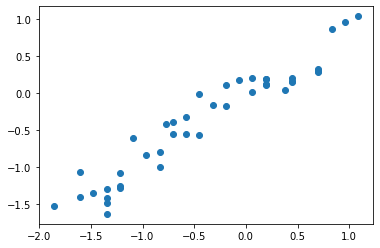

In [537]:
plt.scatter(list(y_test1_shc), list(shc_y_pred1))
plt.show()

In [509]:
X_train2_shc,X_test2_shc,y_train2_shc,y_test2_shc=train_test_split(cluster2_shc_X,cluster2_shc_y,test_size=.2,random_state=1)

In [510]:
shc_reg2=LinearRegression()
shc_reg2.fit(X_train2_shc,y_train2_shc)
shc_y_pred2 = shc_reg2.predict(X_test2_shc)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(shc_reg2.score(X_train2_shc,y_train2_shc)))
# score the model on the test set
print('Test score: {}\n'.format(shc_reg2.score(X_test2_shc,y_test2_shc)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test2_shc,shc_y_pred2)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test2_shc,shc_y_pred2)))

Train score: 0.8768226392525958

Test score: 0.8581450733745164

Overall model accuracy: 0.8581450733745164

Mean Squared Error: 0.11115935801773152


In [534]:
for idx,col in enumerate(cluster2_shc_X.columns):
    print("the coefficients for {} is {}".format(col,shc_reg2.coef_[idx]))

the coefficients for cyl is -0.03803612534104723
the coefficients for yr is 0.07452622512669232
the coefficients for origin is 0.03842574167218436
the coefficients for wt is -0.2563742867766982
the coefficients for hp is -0.2553393876544135
the coefficients for mpg_level_low is -0.387793994895169
the coefficients for mpg_level_Medium is -0.24967399813072488
the coefficients for mpg_level_High is 0.637467993025895


In [511]:
cluster2_shc_X_ = sm.add_constant(cluster2_shc_X)
model = sm.OLS(cluster2_shc_y,cluster2_shc_X)
results = model.fit()

# MSE of the residuals
print(f"MSE: {results.mse_resid}")

# Output Results
results.summary()

MSE: 0.13327236681984087


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     182.4
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           9.73e-79
Time:                        03:44:27   Log-Likelihood:                -74.052
No. Observations:                 190   AIC:                             164.1
Df Residuals:                     182   BIC:                             190.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
cyl                 -0.0273      0.046     -0.599      0.550      -0.117       0.063
yr                   0.0829      0.017      4.860      0.000       0.049       0.117
origin               0.0246      0.038      0.640      0.523      -0.051       0.100
wt                  -0.2904      0.090     -3.210      0.002      -0.469      -0.112
hp                  -0.2266      0.064     -3.521      0.001      -0.354      -0.100
mpg_level_low       -0.8962      0.202     -4.430      0.000      -1.295      -0.497
mpg_level_Medium    -0.7362      0.199     -3.696      0.000      -1.129      -0.343
mpg_level_High       0.1338      0.230      0.583      0.561      -0.319       0.587
==============================================================================
Omnibus:                       22.462   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.984
Skew:                           0.738   Prob(JB):                     3.08e-07
Kurtosis:                       4.269   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- for cluster 2 adjusted r-squared value is 87
- this means almost 87% of variance is explained by regression line
- from OLS summary it is evident that for this cluster only 
  - yr,wt,mpg_level_low,mpg_level_Medium are significant

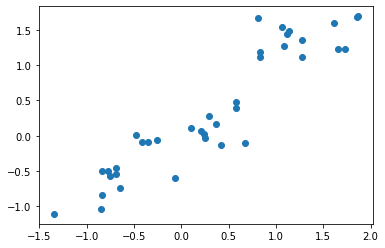

In [538]:
plt.scatter(list(y_test2_shc), list(shc_y_pred2))
plt.show()

## visualize a linear relationship as determined through regression

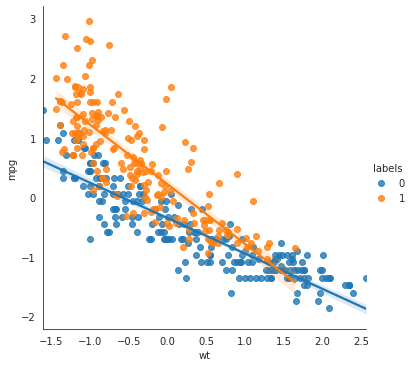

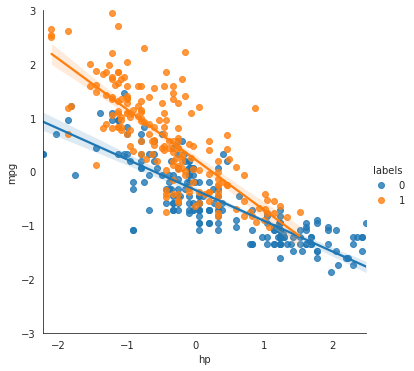

In [539]:
features = ['wt', 'hp',]
with sns.axes_style("white"):
       for var in features:
            plot = sns.lmplot(x=var,y='mpg',data=car_data,hue="labels")
            
plot.set(ylim = (-3,3))

## Linear Regression on whole Dataset

In [513]:
car_data_original=car_data.copy()

In [514]:
car_data_original.drop("labels",axis=1,inplace=True)

In [515]:
X=car_data_original.drop("mpg",axis=1)
y=car_data_original["mpg"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)

In [516]:
model_reg= LinearRegression()
model_reg.fit(X_train,y_train)
y_pred = model_reg.predict(X_test)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(model_reg.score(X_train,y_train)))
# score the model on the test set
print('Test score: {}\n'.format(model_reg.score(X_test,y_test)))
# calculate the overall accuracy of the model
print('r2 score: {}\n'.format(r2_score(y_test,y_pred)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,y_pred)))

Train score: 0.8970042686748441

Test score: 0.9047123272647444

r2 score: 0.9047123272647444

Mean Squared Error: 0.08810233723789956


In [517]:
X_ = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

# MSE of the residuals
print(f"MSE: {results.mse_resid}")

# Output Results
results.summary()

MSE: 0.10280089723351211


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     497.4
Date:                Sun, 04 Apr 2021   Prob (F-statistic):          5.23e-190
Time:                        03:46:07   Log-Likelihood:                -107.98
No. Observations:                 398   AIC:                             232.0
Df Residuals:                     390   BIC:                             263.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
cyl                 -0.0883      0.027     -3.246      0.001      -0.142      -0.035
yr                   0.0490      0.006      8.796      0.000       0.038       0.060
origin               0.0259      0.026      0.979      0.328      -0.026       0.078
wt                  -0.3034      0.047     -6.404      0.000      -0.396      -0.210
hp                  -0.0862      0.036     -2.415      0.016      -0.156      -0.016
mpg_level_low       -0.4894      0.088     -5.589      0.000      -0.661      -0.317
mpg_level_Medium    -0.2882      0.078     -3.699      0.000      -0.441      -0.135
mpg_level_High       0.6256      0.106      5.897      0.000       0.417       0.834
==============================================================================
Omnibus:                       46.726   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.581
Skew:                           0.677   Prob(JB):                     5.82e-20
Kurtosis:                       4.873   Cond. No.                         65.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- for Single linear regression adjusted r-squared value is .90
- this means almost 90% of variance is explained by regression line
- from OLS summary it is evident that all the features except origin are significant

## conclusion
- out of KMeans and Hierarchical clustering Hierarchical clustering is performing better than KMeans
- but if we compare the single linear regression model with hierarchical clustering tan single Linear regression model is performing better than hierarchichal clustering
- Kmeans clustering and hirarchical clustering seems to be inappropriate clustering methodolgy for this dataset coz it is a combintion of oth categorical and numerical features
- kprototype clustering will be the effective way of clustering this dataset